In [1]:
import numpy as np

import matplotlib.pyplot as plt



import torch

import torch.nn as nn

import torch.nn.functional as F

import torch.optim as optim

from torch.utils.data import Subset

from torch.utils.data import DataLoader

from torch.utils.data import random_split



import torchvision

import torchvision.transforms as transforms

from torchvision.models import resnet50, ResNet50_Weights



from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.preprocessing import OneHotEncoder



import time



import importlib

import utils.utils as utils



importlib.reload(utils)

from utils.utils import (

    accuracy,

    train,

    combined_train,

    test,

    combined_test,

    plot_acc,

    plot_loss,

    plot_confusion_matrix,

    save_model,

    get_feature_maps,

    visualize_feature_maps,

    plot_images,

    plot_feature_maps,

)


# Loading CIFAR10 + Preprocess

In [2]:
class OneHotEncode:

    def __init__(self, num_classes):

        self.num_classes = num_classes



    def __call__(self, label):

        return F.one_hot(torch.tensor(label), num_classes=self.num_classes).float()

In [3]:
train_size = 50000

val_size = 10000

test_size = 10000

mean = [0.5, 0.5, 0.5]

std = [0.5, 0.5, 0.5]

num_classes = 2



torch.manual_seed(13)

np.random.seed(13)



transform = transforms.Compose(

    [transforms.ToTensor(), transforms.Normalize(mean=mean, std=std)]

)



label_transform = OneHotEncode(num_classes=num_classes)



train_dataset = torchvision.datasets.CIFAR10(

    root="./data",

    train=True,

    download=True,

    transform=transform,

    target_transform=label_transform,

)



test_dataset = torchvision.datasets.CIFAR10(

    root="./data",

    train=False,

    download=True,

    transform=transform,

    target_transform=label_transform,

)

100%|██████████| 170498071/170498071 [00:07<00:00, 21763577.80it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# Extracting <kbd>airplane</kbd> and <kbd>automobile</kbd>

In [4]:
classes = train_dataset.classes

automobile_index = train_dataset.class_to_idx["automobile"]

airplane_index = train_dataset.class_to_idx["airplane"]





print(classes)

print(f"automobile: {automobile_index}")

print(f"airplane: {airplane_index}")

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
automobile: 1
airplane: 0


In [5]:
indices = [airplane_index, automobile_index]

classes = np.array(classes)[indices].tolist()



train_indices = np.where(np.isin(train_dataset.targets, indices))[0]

test_indices = np.where(np.isin(test_dataset.targets, indices))[0]



train_subset = Subset(train_dataset, train_indices)

test_subset = Subset(test_dataset, test_indices)



train_subset, val_subset = random_split(train_subset, [0.8, 0.2])

In [6]:
train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)

val_loader = DataLoader(val_subset, batch_size=64, shuffle=True)

test_loader = DataLoader(test_subset, batch_size=64, shuffle=True)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"device: {device.type}")

device: cuda


# Defining Model

In [8]:
class CombinedModel(nn.Module):

    def __init__(self, embedding_size=128, num_classes=10):

        super(CombinedModel, self).__init__()

        self.backbone = resnet50(weights=ResNet50_Weights.DEFAULT)

        num_features = self.backbone.fc.in_features



        self.backbone.fc = nn.Identity()

        self.embedding = nn.Linear(num_features, embedding_size)

        self.classifier = nn.Linear(num_features, num_classes)



    def forward(self, x):

        features = self.backbone(x)



        embeddings = nn.functional.normalize(self.embedding(features), p=2, dim=1)

        class_scores = self.classifier(features)

        return embeddings, class_scores

## 1) Cross Entropy Loss

### Loading Pre-Trained Model


In [9]:
model = resnet50(weights=ResNet50_Weights.DEFAULT)

num_features = model.fc.in_features

model.fc = nn.Linear(num_features, num_classes)



for param in model.parameters():

    param.requires_grad = False



for param in model.fc.parameters():

    param.requires_grad = True

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 213MB/s]


In [10]:
model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.fc.parameters())

### Training ResNet50 for Classification

In [11]:
start_time = time.time()

epochs = 30



train_losses, train_accuracies, validation_losses, validation_accuracies = train(

    model=model,

    train_loader=train_loader,

    val_loader=val_loader,

    optimizer=optimizer,

    criterion=criterion,

    device=device,

    epochs=epochs,

    log=True,

)



end_time = time.time()

print(f"time: {np.round(end_time - start_time, 2)} seconds")

Epoch 5/30, Train loss: 22.879, Train acc: 0.85, Val loss: 23.285, Val acc: 0.857
Epoch 10/30, Train loss: 23.332, Train acc: 0.848, Val loss: 23.158, Val acc: 0.855
Epoch 15/30, Train loss: 23.157, Train acc: 0.846, Val loss: 22.761, Val acc: 0.857
Epoch 20/30, Train loss: 22.601, Train acc: 0.855, Val loss: 24.828, Val acc: 0.851
Epoch 25/30, Train loss: 23.293, Train acc: 0.853, Val loss: 24.145, Val acc: 0.85
Epoch 30/30, Train loss: 22.152, Train acc: 0.849, Val loss: 23.9, Val acc: 0.86
time: 134.24 seconds


### Plotting Loss and Accuracy

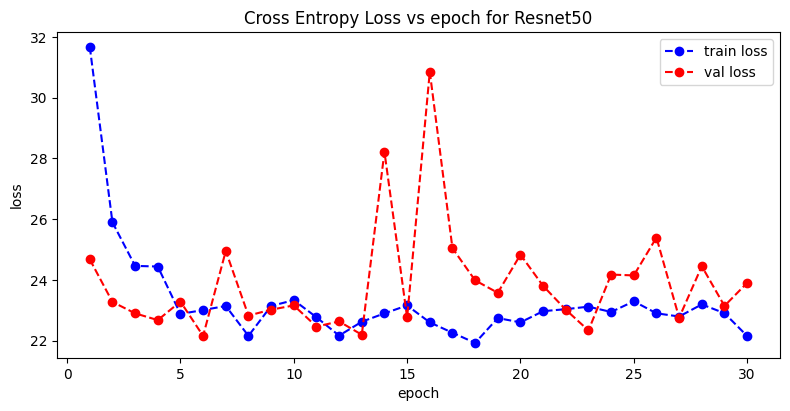

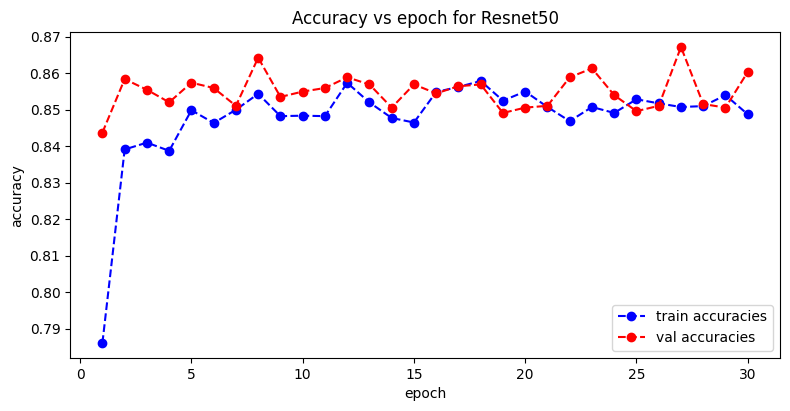

In [12]:
plot_loss(

    train_losses,

    validation_losses,

    epochs=epochs,

    title="Cross Entropy Loss vs epoch for Resnet50",

)

plot_acc(

    train_accuracies,

    validation_accuracies,

    epochs=epochs,

    title="Accuracy vs epoch for Resnet50",

)

### Plotting Feature Maps

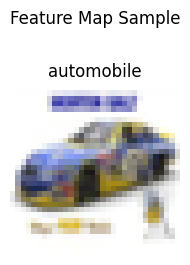

feature map size: torch.Size([1, 64, 16, 16])


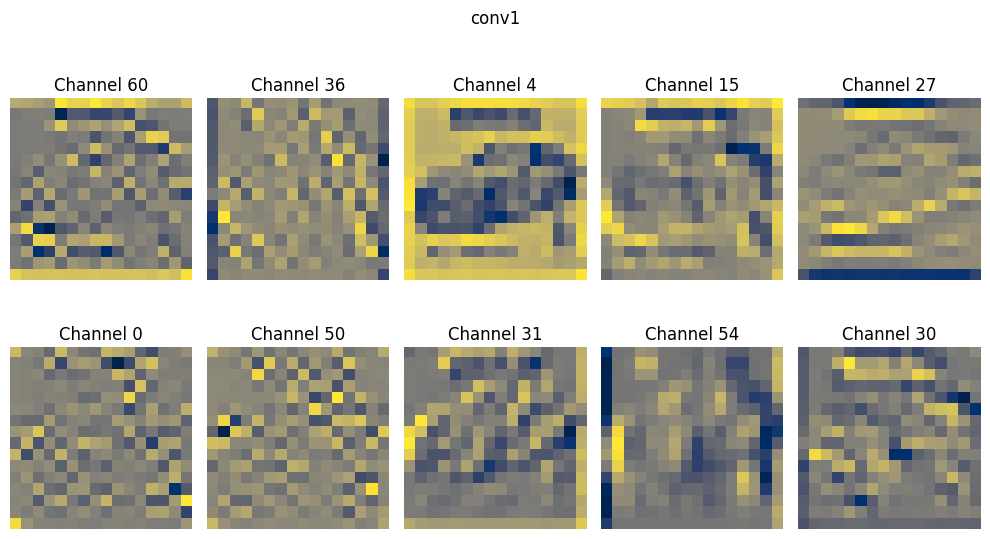

feature map size: torch.Size([1, 256, 8, 8])


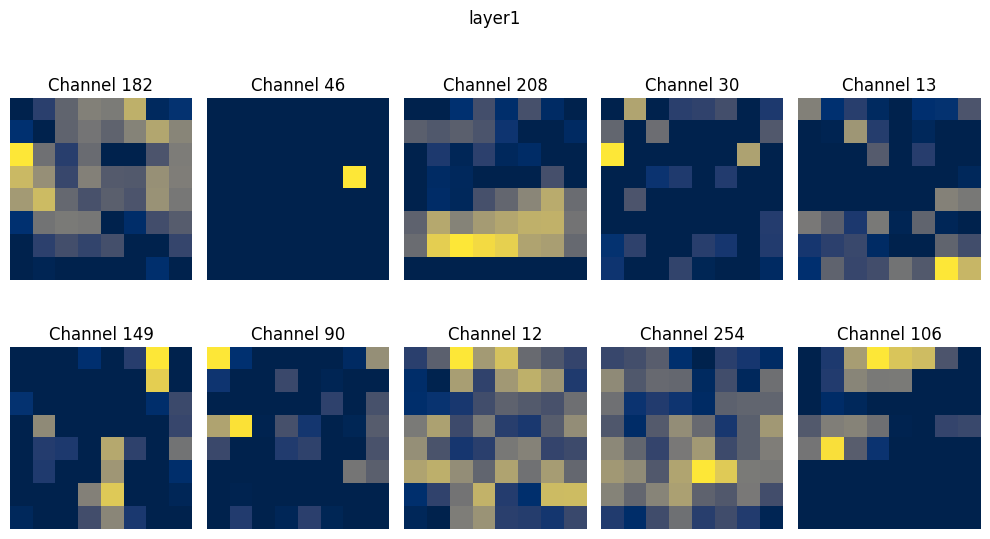

feature map size: torch.Size([1, 512, 4, 4])


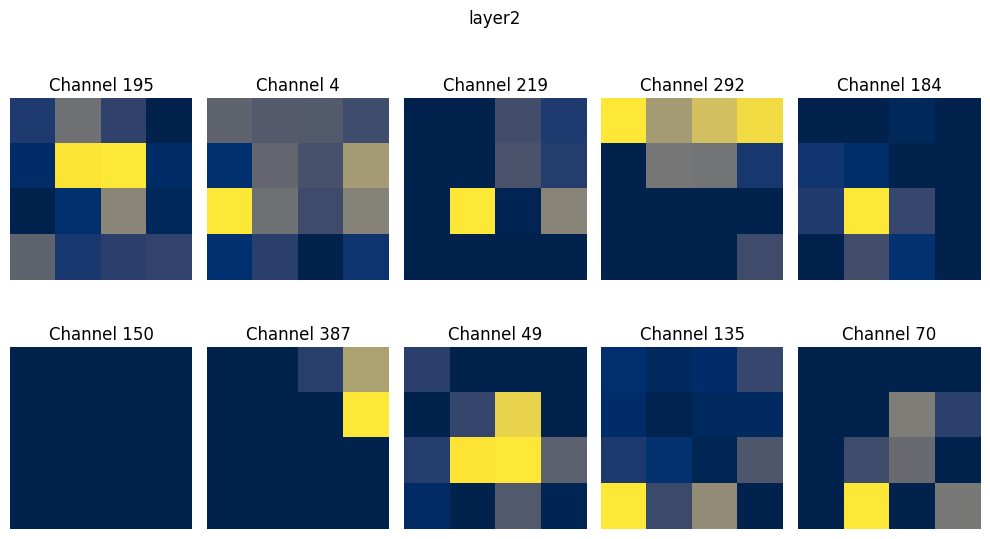

feature map size: torch.Size([1, 1024, 2, 2])


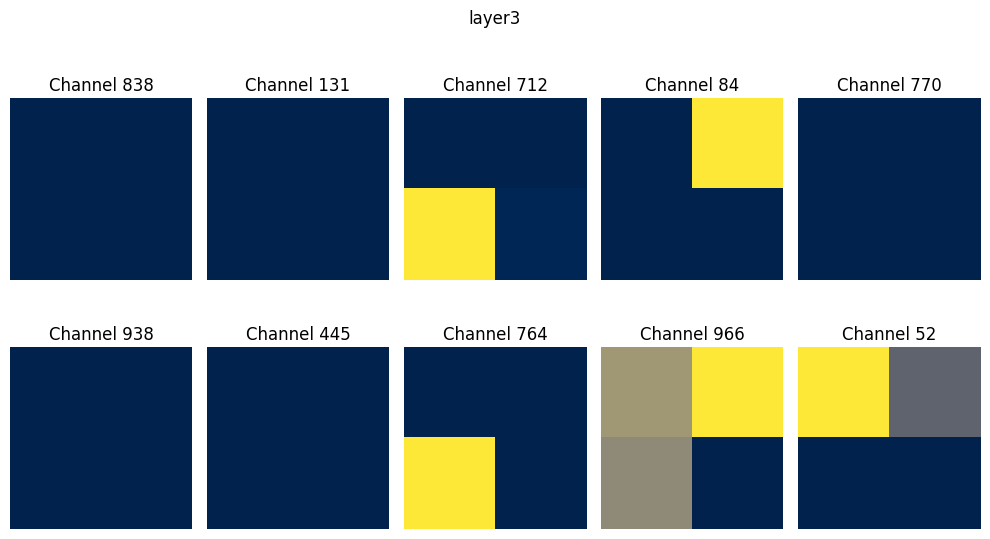

In [13]:
images, labels = next(iter(train_loader))

image, label = images[0], classes[torch.argmax(labels[0])]

plot_images([image], mean, std, [label], title="Feature Map Sample")



plot_feature_maps(model, image, device)

## 2) Triplet Loss

### Preparing Dataset

In [14]:
class TripletDataset(torch.utils.data.Dataset):

    def __init__(self, dataset, triplets):

        self.dataset = dataset

        self.triplets = triplets



    def __len__(self):

        return len(self.triplets)



    def __getitem__(self, idx):

        anchor_idx, positive_idx, negative_idx = self.triplets[idx]

        anchor, label = self.dataset[anchor_idx]

        positive, _ = self.dataset[positive_idx]

        negative, _ = self.dataset[negative_idx]

        return (anchor, positive, negative), label





def make_triplets(dataset):

    triplets = []

    class_indices = {}



    for idx, (_, label) in enumerate(dataset):

        c = classes[torch.argmax(label)]

        if c not in class_indices:

            class_indices[c] = []

        class_indices[c].append(idx)



    for c in class_indices:

        for idx in class_indices[c]:

            anchor_idx = idx



            positive_idx = np.random.choice(

                [i for i in class_indices[c] if i != anchor_idx]

            )



            negative_class = np.random.choice(

                [label for label in class_indices.keys() if label != c]

            )

            negative_idx = np.random.choice(class_indices[negative_class])



            triplets.append((anchor_idx, positive_idx, negative_idx))



    return triplets

### Making Triplets

In [15]:
trian_triplets = make_triplets(train_subset)

val_triplets = make_triplets(val_subset)

test_triplets = make_triplets(test_subset)



train_triplet_dataset = TripletDataset(train_subset, trian_triplets)

val_triplet_dataset = TripletDataset(val_subset, val_triplets)

test_triplet_dataset = TripletDataset(test_subset, test_triplets)

In [16]:
train_loader = DataLoader(

    train_triplet_dataset, batch_size=64, shuffle=True

)

val_loader = DataLoader(val_triplet_dataset, batch_size=64, shuffle=True)

test_loader = DataLoader(

    test_triplet_dataset, batch_size=64, shuffle=True

)

### Training ResNet50 for Feature Extracting + Feature Maps

In [17]:
num_embeddings = 128

triplet_model = CombinedModel(embedding_size=num_embeddings, num_classes=num_classes)

In [18]:
triplet_model.to(device)

criterion = nn.TripletMarginLoss(margin=1, p=2)

optimizer = optim.Adam(triplet_model.parameters())

In [19]:
start_time = time.time()

epochs = 30



train_losses, train_accuracies, validation_losses, validation_accuracies = (

    combined_train(

        model=triplet_model,

        train_loader=train_loader,

        val_loader=val_loader,

        optimizer=optimizer,

        criterion=criterion,

        device=device,

        epochs=epochs,

        log=True,

        mode="triplet",

    )

)



end_time = time.time()

print(f"time: {np.round(end_time - start_time, 2)} seconds")

Epoch 5/30, Train loss: 3.289, Train acc: 0.96, Val loss: 7.012, Val acc: 0.956
Epoch 10/30, Train loss: 1.466, Train acc: 0.939, Val loss: 7.267, Val acc: 0.905
Epoch 15/30, Train loss: 5.506, Train acc: 0.9, Val loss: 10.829, Val acc: 0.897
Epoch 20/30, Train loss: 2.231, Train acc: 0.986, Val loss: 7.11, Val acc: 0.966
Epoch 25/30, Train loss: 1.262, Train acc: 0.992, Val loss: 6.936, Val acc: 0.969
Epoch 30/30, Train loss: 0.447, Train acc: 0.997, Val loss: 6.454, Val acc: 0.972
time: 558.82 seconds


### Plotting Loss

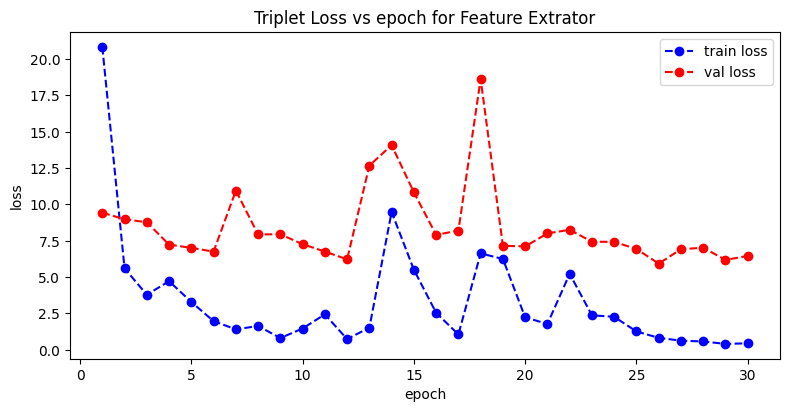

In [20]:
plot_loss(

    train_losses,

    validation_losses,

    epochs=epochs,

    title="Triplet Loss vs epoch for Feature Extrator",

)

### Training ResNet50 for Classification

In [21]:
for param in triplet_model.parameters():

    param.requires_grad = False



for param in triplet_model.classifier.parameters():

    param.requires_grad = True

In [22]:
triplet_model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(triplet_model.classifier.parameters())

In [23]:
start_time = time.time()

epochs = 30



train_losses, train_accuracies, validation_losses, validation_accuracies = (

    combined_train(

        model=triplet_model,

        train_loader=train_loader,

        val_loader=val_loader,

        optimizer=optimizer,

        criterion=criterion,

        device=device,

        epochs=epochs,

        log=True,

        mode="default",

    )

)



end_time = time.time()

print(f"time: {np.round(end_time - start_time, 2)} seconds")

Epoch 5/30, Train loss: 2.783, Train acc: 0.996, Val loss: 6.242, Val acc: 0.975
Epoch 10/30, Train loss: 1.719, Train acc: 0.997, Val loss: 6.956, Val acc: 0.975
Epoch 15/30, Train loss: 1.382, Train acc: 0.996, Val loss: 6.848, Val acc: 0.974
Epoch 20/30, Train loss: 1.398, Train acc: 0.996, Val loss: 6.398, Val acc: 0.974
Epoch 25/30, Train loss: 1.089, Train acc: 0.996, Val loss: 6.309, Val acc: 0.97
Epoch 30/30, Train loss: 1.151, Train acc: 0.996, Val loss: 5.78, Val acc: 0.974
time: 233.77 seconds


### Plotting Loss and Accuracy

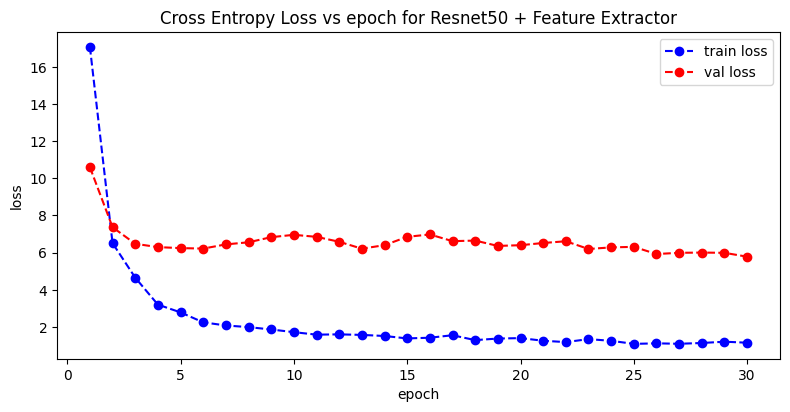

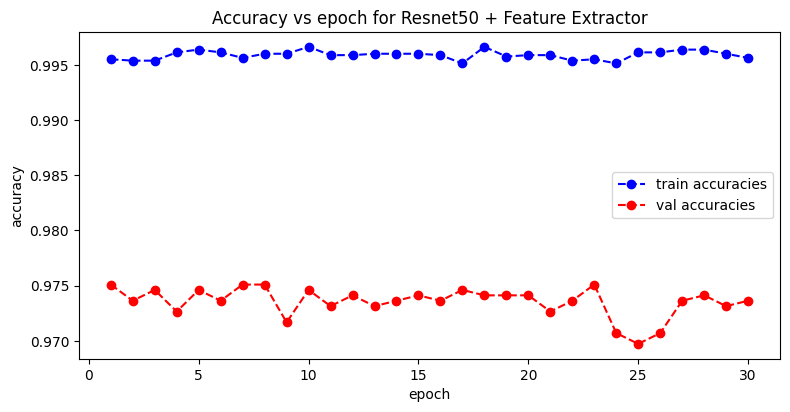

In [24]:
plot_loss(

    train_losses,

    validation_losses,

    epochs=epochs,

    title="Cross Entropy Loss vs epoch for Resnet50 + Feature Extractor",

)

plot_acc(

    train_accuracies,

    validation_accuracies,

    epochs=epochs,

    title="Accuracy vs epoch for Resnet50 + Feature Extractor",

)

### Testing on Test Dataset

loss= 6.533, accuracy= 0.974


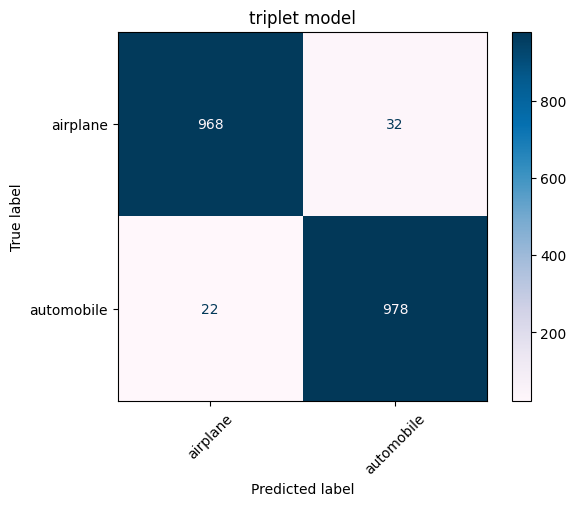

In [25]:
loss, acc, preds, labels = combined_test(

    triplet_model, test_loader, criterion, device, mode="default"

)

print(f"loss= {np.round(loss, 3)}, accuracy= {np.round(acc, 3)}")

plot_confusion_matrix(labels, preds, class_names=classes, title="triplet model")

#TODO

## 3) Conclusion and Comparison

#TODO

## 4) Loss Combination

In [26]:
num_embeddings = 128

combined_model = CombinedModel(embedding_size=num_embeddings, num_classes=num_classes)

In [27]:
combined_model.to(device)

criterion = [nn.CrossEntropyLoss(), nn.TripletMarginLoss(margin=1, p=2)]

optimizer = optim.Adam(combined_model.parameters())

In [28]:
start_time = time.time()

epochs = 30



train_losses, train_accuracies, validation_losses, validation_accuracies = (

    combined_train(

        model=combined_model,

        train_loader=train_loader,

        val_loader=val_loader,

        optimizer=optimizer,

        criterion=criterion,

        device=device,

        epochs=epochs,

        log=True,

        mode="combined",

    )

)



end_time = time.time()

print(f"time: {np.round(end_time - start_time, 2)} seconds")

Epoch 5/30, Train loss: 1.644, Train acc: 0.996, Val loss: 10.297, Val acc: 0.977
Epoch 10/30, Train loss: 1.846, Train acc: 0.996, Val loss: 15.496, Val acc: 0.965
Epoch 15/30, Train loss: 0.932, Train acc: 0.998, Val loss: 10.244, Val acc: 0.98
Epoch 20/30, Train loss: 1.583, Train acc: 0.996, Val loss: 13.795, Val acc: 0.975
Epoch 25/30, Train loss: 0.744, Train acc: 0.998, Val loss: 10.872, Val acc: 0.977
Epoch 30/30, Train loss: 1.63, Train acc: 0.996, Val loss: 10.754, Val acc: 0.973
time: 559.67 seconds


### Testing on Test Dataset

loss= 12.118, accuracy= 0.974


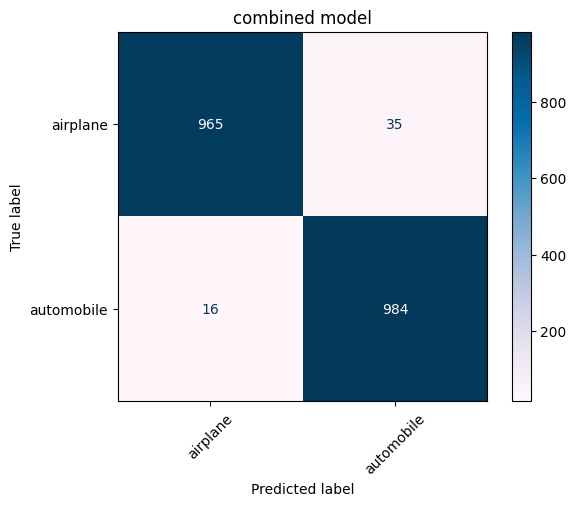

In [29]:
loss, acc, preds, labels = combined_test(

    combined_model, test_loader, criterion, device, mode="combined"

)

print(f"loss= {np.round(loss, 3)}, accuracy= {np.round(acc, 3)}")

plot_confusion_matrix(labels, preds, class_names=classes, title="combined model")

#TODO